<a href="https://colab.research.google.com/github/bineee39/first-repository/blob/master/WRAP_UP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 정리
- 사용할 데이터는 PJM의 시간당 전력 소비량 데이터이다(2002년부터 2018년까지 동부 지역 전체 데이터).

- 시간,계절 등 몇 가지 고유한 특징을 가지고있다.

- Prophet(프로핏)이라는 모델을 사용하여 이러한 특징을 얼마나 잘 포착해내는지 확인하는 것이 목적


In [41]:
import sys

# Uninstall potentially incompatible versions first
!{sys.executable} -m pip uninstall -y pystan cmdstanpy fbprophet

# Install the 'prophet' library (the newer version of fbprophet)
!{sys.executable} -m pip install prophet

Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)


In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [43]:
pjme = pd.read_csv('./PJME_hourly.csv',
                   index_col=[0], parse_dates=[0])

첫번째 열이 시간 데이터이므로 칼럼으로 선정하고, parse_dates로 pandas가 해당 열을 datetime으로 파싱하도록 지시.

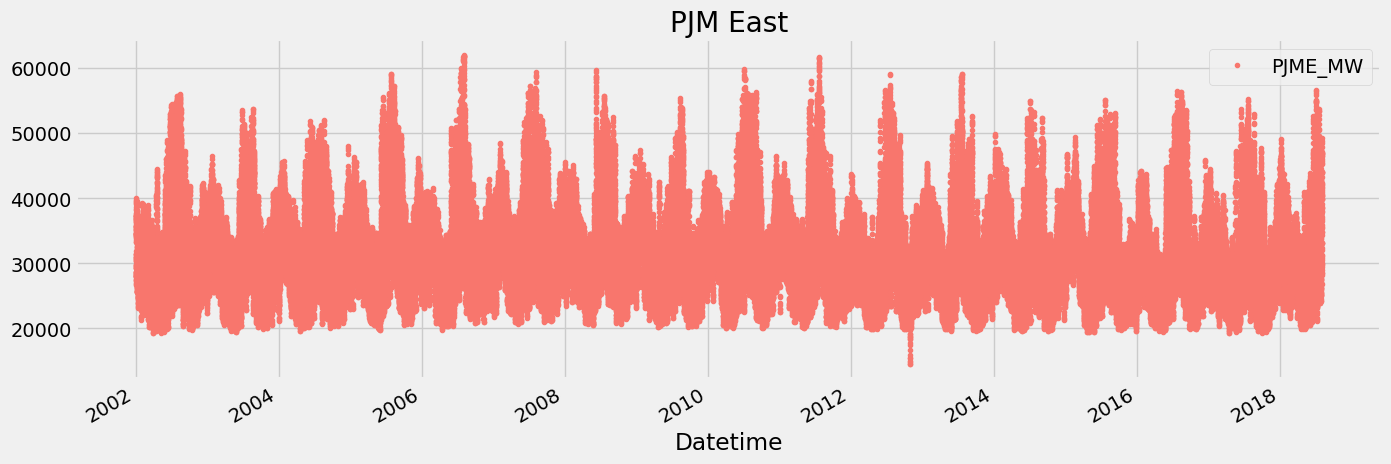

In [44]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

주기적으로 반복되는 패턴이 보인다

# EDA
시간대(hour), 요일(day of week), 연중 시기(time of year) 등과 같은 요소들이 (전력 소비량) 추세에 어떻게 영향을 미치는지 알아보기 위해 몇 가지 시계열 특성(features)을 생성할 것

In [45]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

파이썬 버전이 달라짐에 따라 weekofyear를 사용할 수 없음.

isocalendar().week 를 통해 연도, 주차, 요일을 뽑아낸 뒤 거기서 week만 가져옴

In [46]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

    df['date'] = df.index
    -> 현재 인덱스에 있는 날짜 정보를 date라는 새로운 컬럼으로 만듦
    ->인덱스에 있는 값보다 컬럼에 있는 값으로 다루는 게 뒤에 나올 .dt 명령어를 쓰기 편할 때가 많아서

    .dt는 "datetime(날짜시간) 접근자"라고 해서, 날짜 데이터에서 원하는 정보만 쏙쏙 뽑아내는 도구


    df['hour'] = df['date'].dt.hour
    -> 시간추출

    df['dayofweek'] = df['date'].dt.dayofweek
    ->요일을 0-6까지 숫자로 추출

    df['quarter'] = df['date'].dt.quarter
    -> 1-4분기 추출
    
    df['month'] = df['date'].dt.month
    -> 1-12월 추출

    df['year'] = df['date'].dt.year
    -> 연도 추출

    df['dayofyear'] = df['date'].dt.dayofyear
    -> 1-365일중 몇번째 날인지 추출

    df['dayofmonth'] = df['date'].dt.day
    -> 그 달의 며칠인지 추출

    df['weekofyear'] = df['date'].dt.isocalendar().week
    ->1년중 몇번째 주인지 추출

### 왜 이러한 특징을 추출?

- 1-365일중 몇번째 날인지 추출

->계절을 알려주는 역할 ,
EX) 200~230(한여름)엔 전력소모가 많구나

- 그 달의 며칠인지 추출

->인간의 사회적 패턴(월간 주기)을 알려주기 위해서,
EX) 공장이나 회사는 월말에 마감을 하느라 전력을 더 많이 쓸 수도 있다

- 1년중 몇번째 주인지 추출

-> 1년 중 특정 시기에 반복되는 이벤트를 잡기 위해서,
EX) (52주차) 크리스마스와 연말 연휴가 있어서 공장 가동이 멈추거나 가정용 전기가 늘어난다.

In [47]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


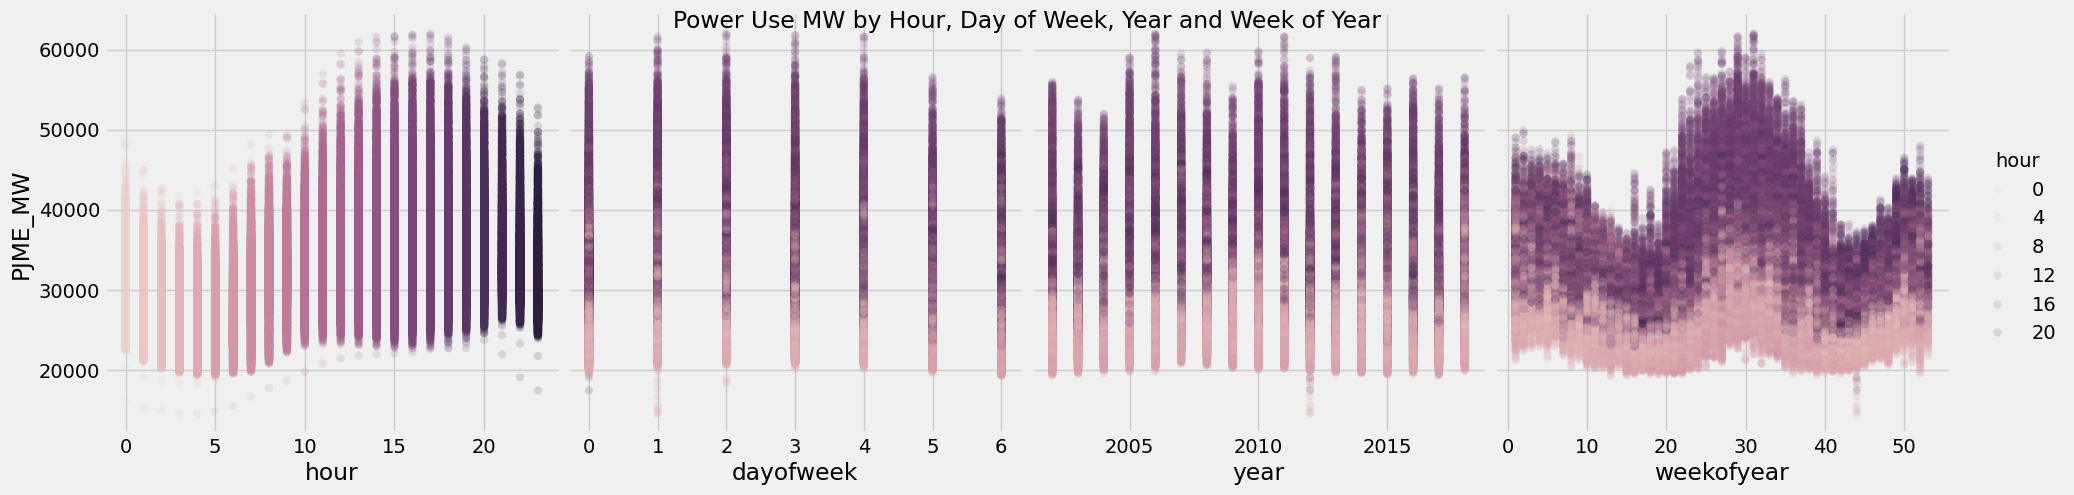

In [48]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

1. hour 시각화

시간대별로 전력의 차이가 있다. 오전 12시 정각부터 새벽 시간대엔 전력 사용량이 적다가 오후,저녁 시간대에 전력 사용량이 늘어난다.

2. dayofweek

0부터 6까지 요일을 숫자로 치환한 데이터 시각화 자료이다. 주말에는 전기 사용량이 주중보다 줄어든 것을 확인할 수 있다.

3. year

2012-2013년도쯤 outlier로 보이는 값이 아래에 분포하고 있는 것을 확인할 수 있다. 또한 어떠한  기간에 따라 전력 사용량이 증가하고 감소하는 주기를 보이는 것 같다.

4. weekofyear

봄과 가을엔 전력 사용이 줄어들고, 여름(가운데 봉우리)과 겨울(양 끝)에 전력 사용량이 늘어나는 것을 확인할 수 있다.


# Train/Test split

- 2015 이후 데이터를 검증 데이터로 사용

In [49]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

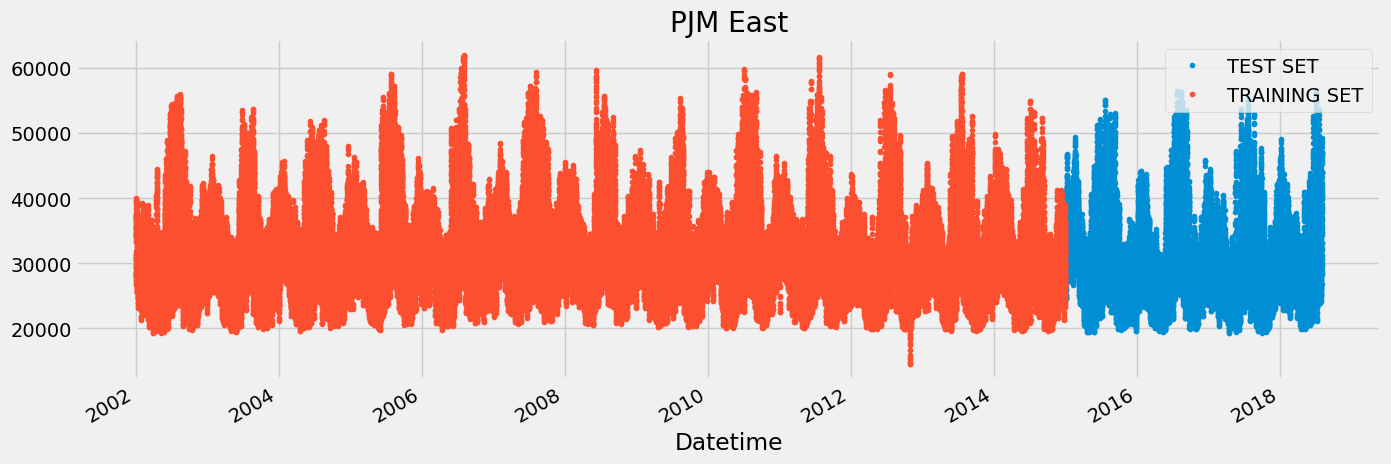

In [50]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

# simple prophet model
- prophet은 시계열의 시간 정보를 칼럼과, 예측하려는 실제 값을 담는 칼럼을 필요로하므로, 모델에 넣기 전에 데이터프레임 칼럼들의 이름을 변경해야함

In [51]:
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [52]:
model = prophet.Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

In [53]:
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [54]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.828952,23798.726221,33072.264348,31210.828952,31210.828952,-2893.744621,-2893.744621,-2893.744621,-4430.274886,...,1281.327002,1281.327002,1281.327002,255.203263,255.203263,255.203263,0.0,0.0,0.0,28317.084331
1,2015-01-01 02:00:00,31210.792144,22472.723881,31459.793523,31210.792144,31210.792144,-4398.241671,-4398.241671,-4398.241671,-5927.275057,...,1272.572288,1272.572288,1272.572288,256.461099,256.461099,256.461099,0.0,0.0,0.0,26812.550473
2,2015-01-01 03:00:00,31210.755336,21521.128244,30373.097899,31210.755336,31210.755336,-5269.976752,-5269.976752,-5269.976752,-6790.348728,...,1262.611487,1262.611487,1262.611487,257.760489,257.760489,257.760489,0.0,0.0,0.0,25940.778583
3,2015-01-01 04:00:00,31210.718527,21123.548420,29992.712265,31210.718527,31210.718527,-5411.458676,-5411.458676,-5411.458676,-6922.128354,...,1251.568218,1251.568218,1251.568218,259.101460,259.101460,259.101460,0.0,0.0,0.0,25799.259851
4,2015-01-01 05:00:00,31210.681719,22206.965357,31206.408977,31210.681719,31210.681719,-4737.020385,-4737.020385,-4737.020385,-6237.082737,...,1239.578314,1239.578314,1239.578314,260.484037,260.484037,260.484037,0.0,0.0,0.0,26473.661334


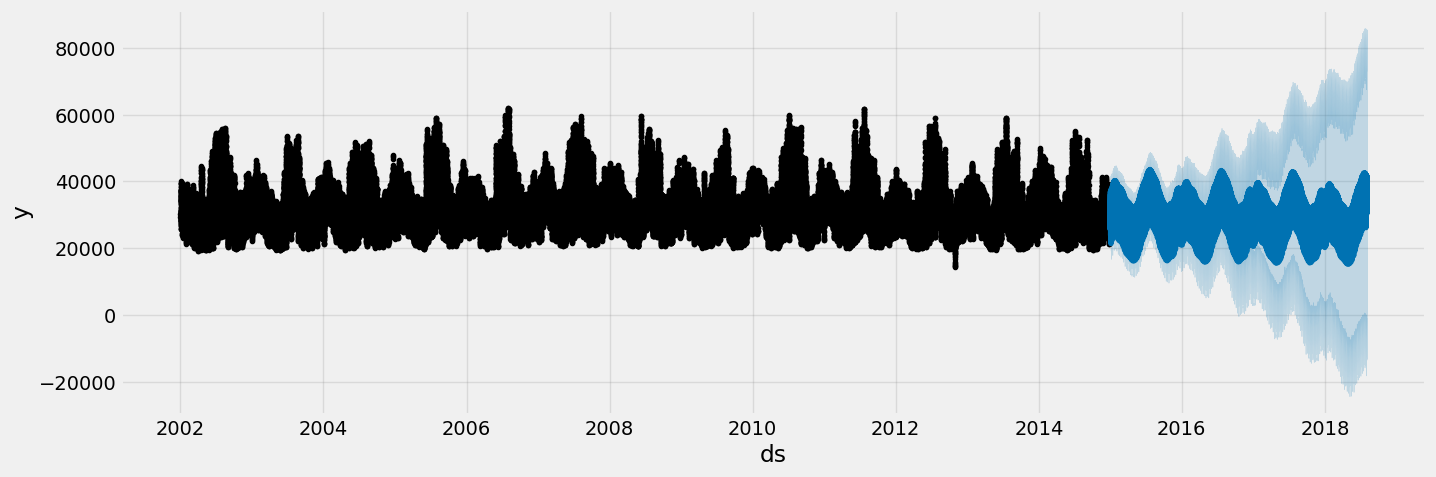

In [55]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

prophet으로 학습한 결과, 예측값은 진한 파란색, 신뢰구간은 옅은 파란색이다.

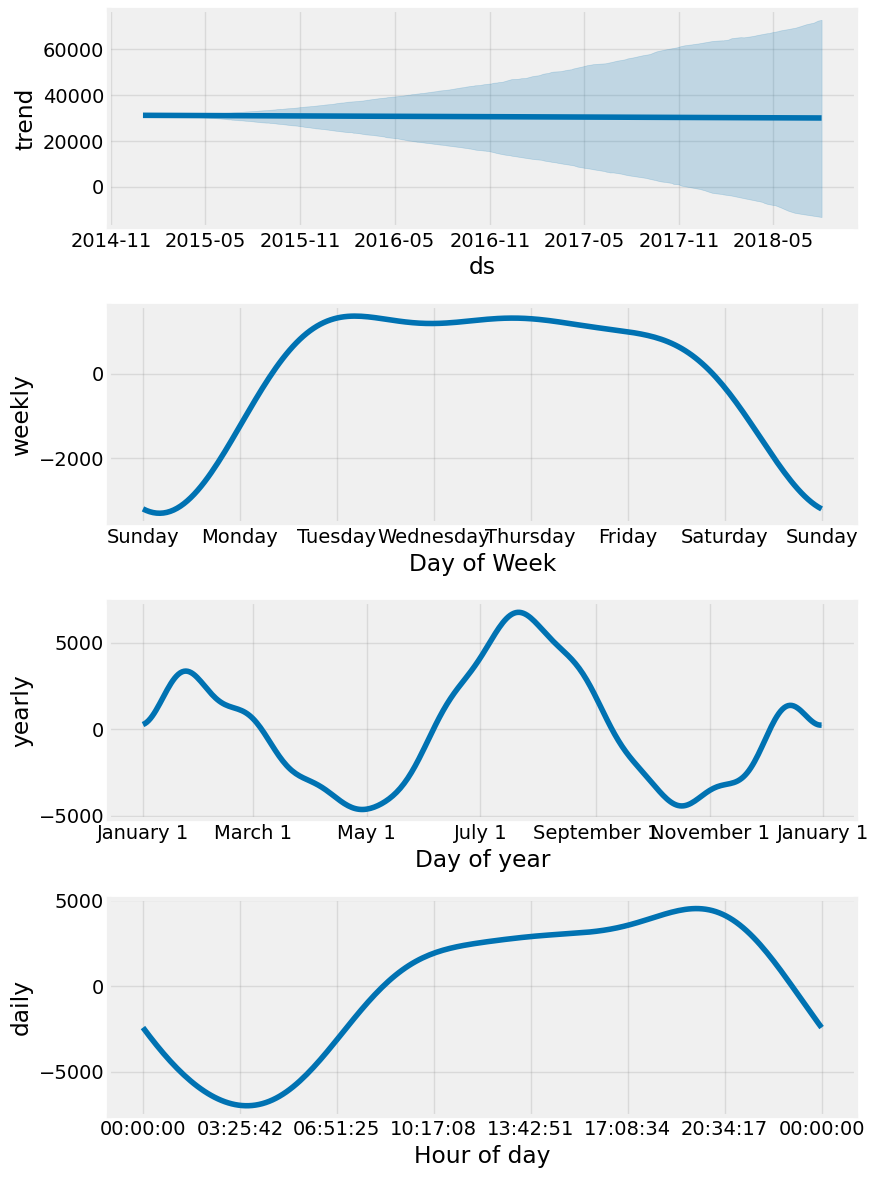

In [56]:
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

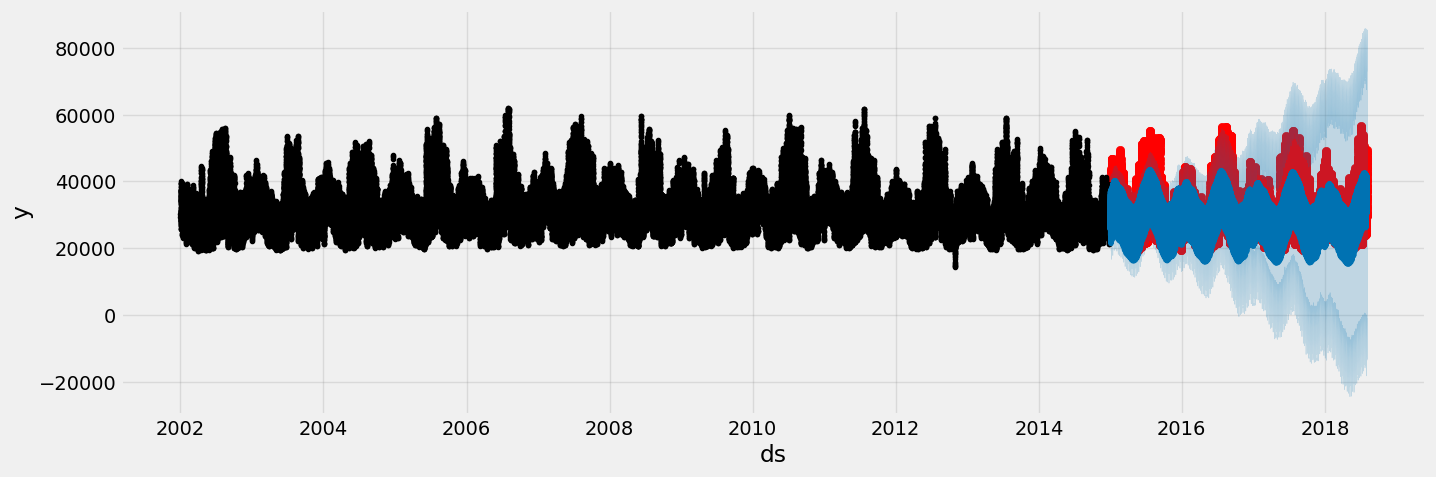

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Look at first month of predictions

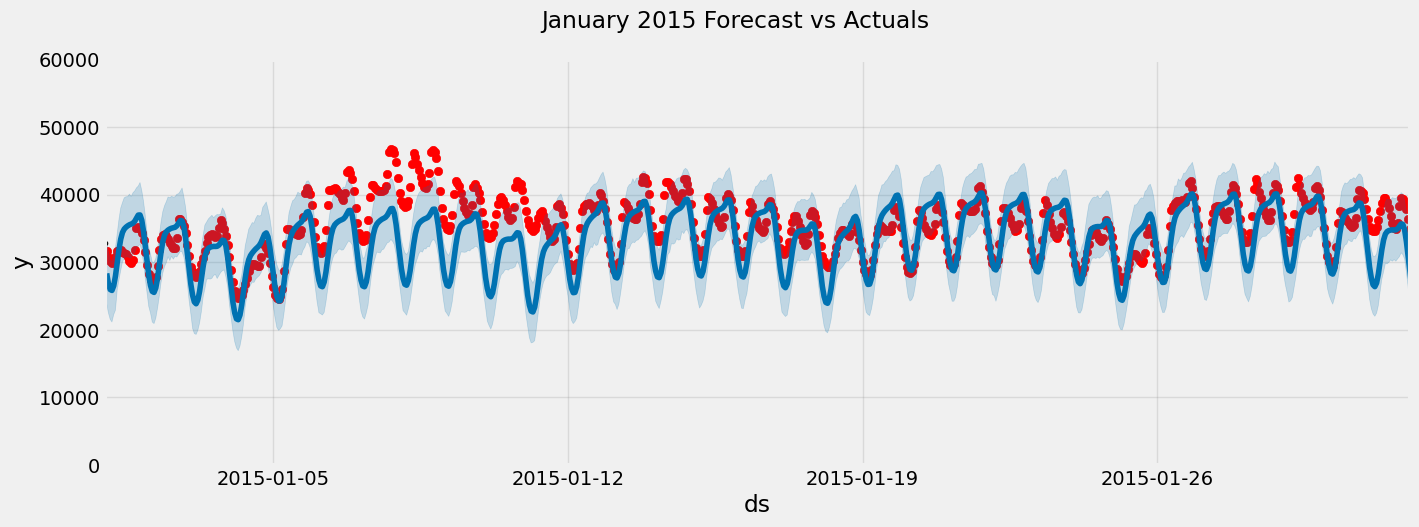

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

 2015년 1월 한 달 동안의 실제 전력 소비량(빨간색 점)과 Prophet 모델의 예측값(짙은 파란색 선), 그리고 예측 신뢰 구간(옅은 파란색 영역)을 시각화한 그래프

# Single Week of Predictions

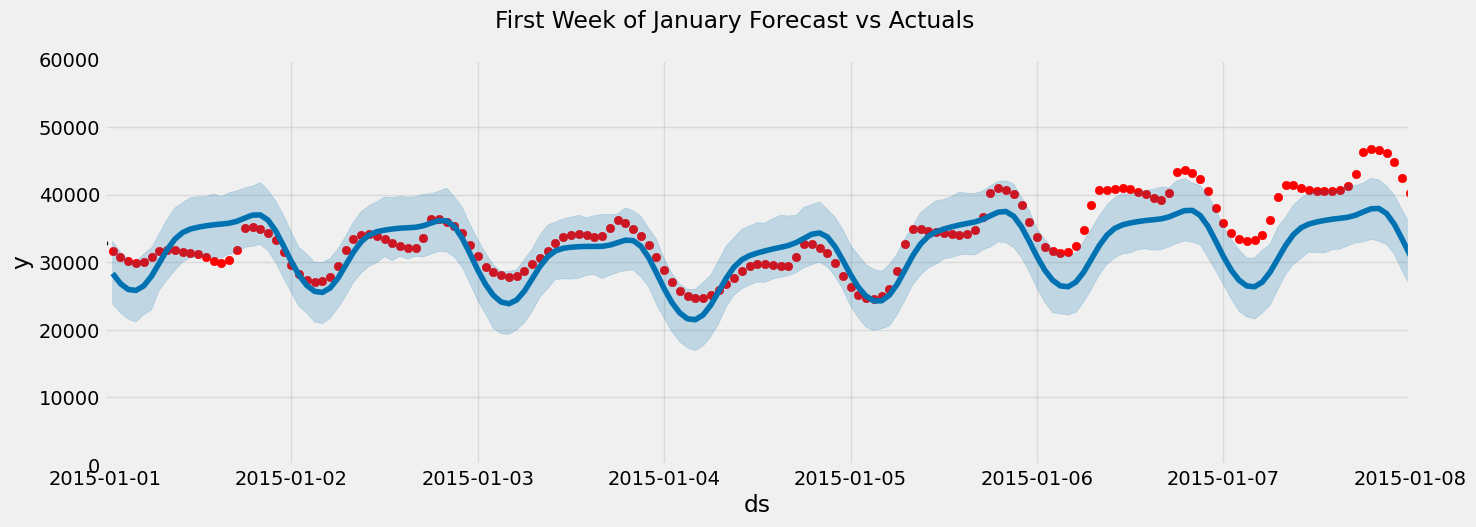

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), upper=pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

2015년 1월 첫째 주의 예측 그래프

# Error Metrics

RMSE error : 43761675

MAE error : 5181.78

MAPE error : 16.5%

코더가 다른 캐글에서 XGBoost모델로 예측때가 오차가 적게 나왔다고 한다 . (8.9% MAPE)

-> prophet은 시계열 데이터의 추세, 계절성 등을 잘 포착하지만 외부변수를 사용하거나 더 복잡한 비선형 관계를 학습하는데에는 XGBoost와 같은 머신러닝이 더 좋은 결과를 낼 수 있다.


In [60]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

43783759.01372544

In [61]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.902492927458

In [62]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(16.512083240542825)

# Adding Holidays

- prophet은 특정 이벤트나 날짜(공휴일)이 데이터에 미치는 영향을 직접적으로 학습하지 않을므로, 이러한 휴일을 별도로 학습시키면 예측 성능을 높일 수 있다.

In [63]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

pandas 라이브러리중 usfederaholidaycalendar를 이용해 미국 연방 공휴일 목록을 생성

pjme_train.index.min()은 훈련 데이터셋의 가장 빠른날짜를,

pjme_train.index.max()은 가장 늦은 날짜를 가져와서 start와 end 범위를 정함

In [64]:
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
#각 행이 공휴일인지 아닌지 불리언 형식으로 칼럼 생성
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
    #true인값만 선택해 칼럼 생성
holiday_df['holiday'] = 'USFederalHoliday'
#모든 연방 공휴일을 하나의 그룹으로 간주
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
#불필요한 칼럼 drop
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [65]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [67]:
model_with_holidays = prophet.Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

#Predict With Holidays

In [68]:
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

#Plot Holiday Effect

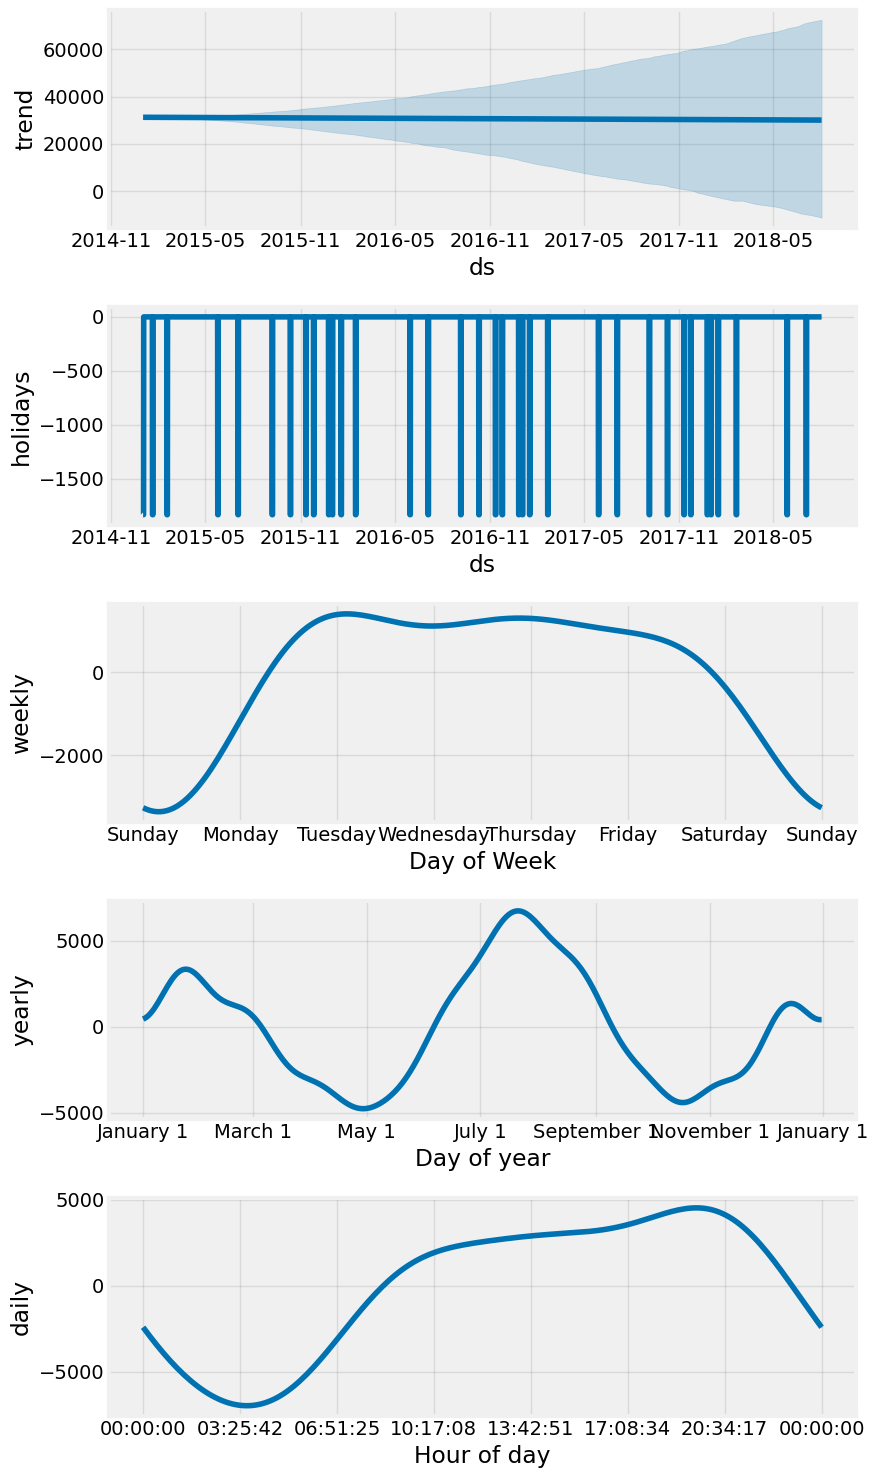

In [69]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

#Error Metrics with Holidays Added

- 오히려 공휴일을 추가하고 error가 더 안좋아졌다

In [70]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43957442.73967408

In [71]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5192.348038855673

In [72]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

np.float64(16.541433856478648)

기존 error

RMSE error : 43761675

MAE error : 5181.78

MAPE error : 16.5%

#Compare Models Just for Holiday Dates

- 일반적인 기간이 아닌, 특별한 이벤트인 휴일에 모델이 어떻게 예측하는지를 중점적으로 비교하겠다.


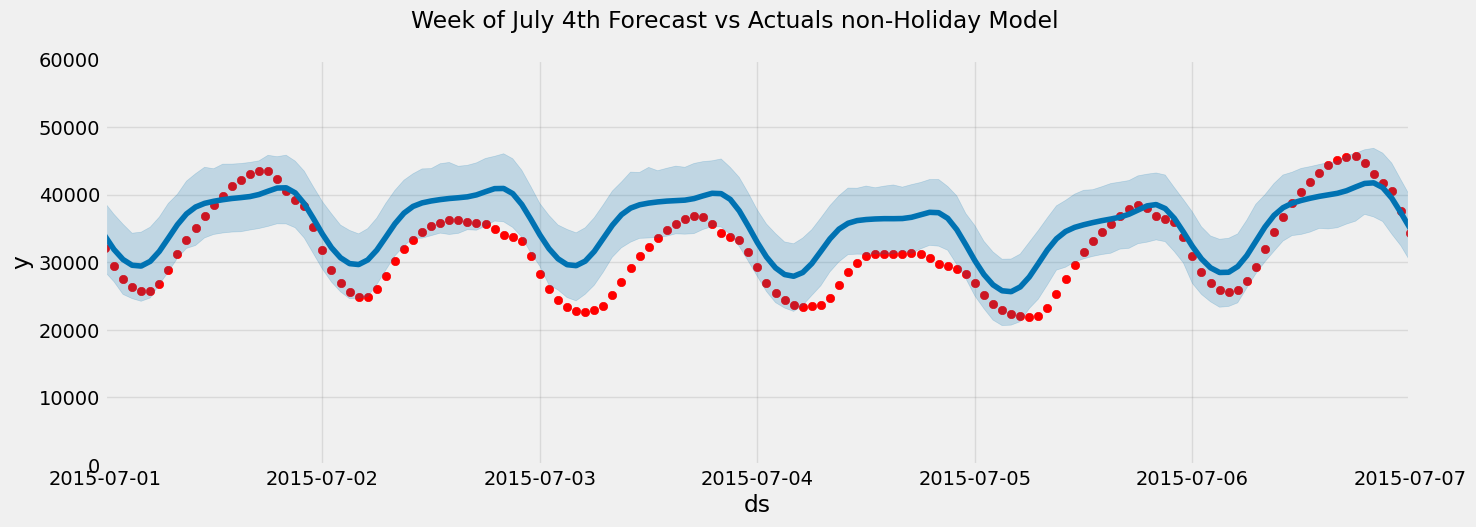

In [74]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('07-01-2015'), upper=pd.to_datetime('07-07-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

7월4일(독립기념일)이 포함된 한 주간의 예측 데이터.
신뢰구간에도 실제값이 잘 매치되지 않는다는 것을 알 수 있다.

#Compare Error for just 4th of July

- prophet 모델에 휴일 정보를 추가한 결과, 7월 4일(독립기념일) 에 대한 예측오차가 감소하긴 하였다.

In [77]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [78]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2156.4578934139904

In [79]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2149.503900827453

기존 error

RMSE error : 43761675

MAE error : 5181.78

MAPE error : 16.5%

#Error of all Holidays

- 모든 공휴일에 대한 평균오차가 오히려 증가했다

In [80]:
holiday_list = holiday_df['ds'].tolist()

공휴일 날짜 리스트로 따로 저장

In [81]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
#공휴일의 전력 소비량 데이터만 추출해 저장

In [82]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5217.65855468931

In [83]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5115.242229629228

#Identify Error by holiday

- 모델에서 각기 다른 휴일들이 다르게 반응하는 것을 알 수 있다. 특정 휴일(독립기념일)에는 예측 정확도가 향상되었지만 다른 휴일에서는 오히려 예측 정확도가 떨어졌다.

- usfederalholiday라는 하나의 일반적인 카테고리로 묶기보다 각 공휴일을 구체적으로 식별한다면 모델 성능이 더 향상될 것이다

In [84]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3077.6 
 MAE (Holiday Model): 2671.1 
 Diff 406.6
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2400.7 
 MAE (Holiday Model): 2088.2 
 Diff 312.5
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11149.5 
 MAE (Holiday Model): 12793.5 
 Diff -1644.0
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1565.0 
 MAE (Holiday Model): 1626.1 
 Diff -61.1
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6079.2 
 MAE (Holiday Model): 4295.6 
 Diff 1783.5
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.9 
 MAE (Holiday Model): 4321.7 
 Diff -469.7
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1592.1 
 MAE (Holiday Model): 1882.9 
 Diff -290.9
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2046.9 
 MAE (Holiday Model): 1586.2 
 Diff 460.7
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4660.2 
 MAE (Holiday Model): 3777.5 
 Diff 882.7
Holiday: December 25, 2015:    


각각의 개별 휴일별로 예측 오차를 비교분석하는 코드.

이를 통해 휴일 정보를 모델에 추가하는 것이 휴일에 어떤 영향을 미치는지 구체적으로 파악할 수 있다.

결과적으로도 diff값이 양수 또는 음수 값으로 나타나, 휴일의 종류에 따라 모델의 반응이 달랐음을 확인할 수 있다.

#Plot Error of Each Forecast

- 각 예측의 오차 시각화
- 두 모델 모두 일반화는 잘 되지만 최대 수요가 발생하는 날에는 어려움을 겪는 것을 알 수 있다.
- 많은 날들에 대해 과소 예측하는 경향이 있는 것으로 보임

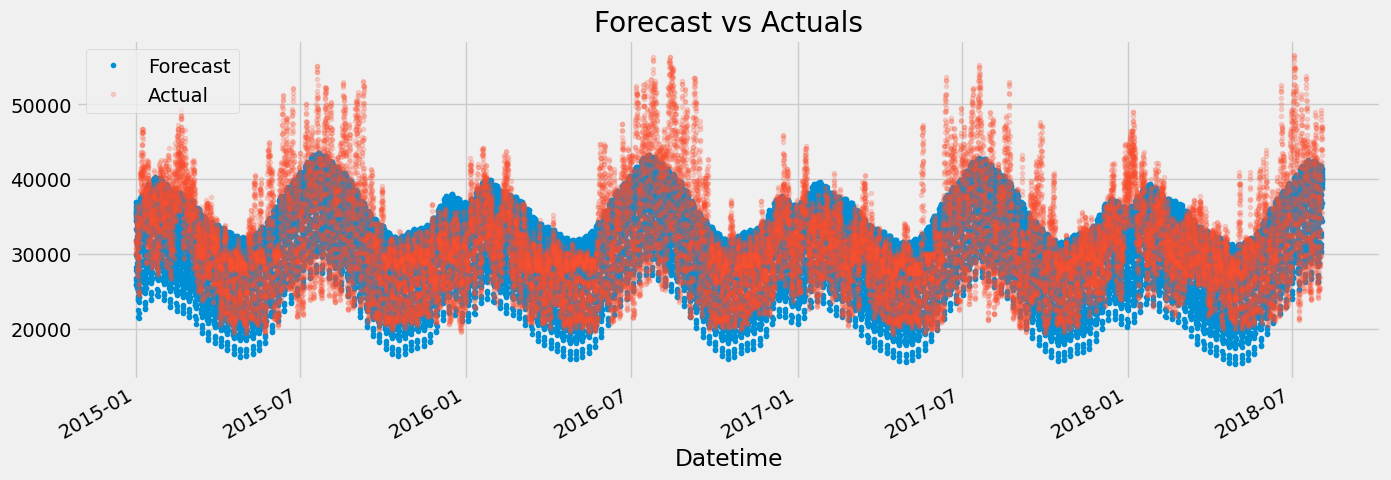

In [85]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

#Data Cleaning

- 데이터 클리닝은 데이터셋에서 부정확하거나 불완전하거나 관련성이 없거나 잘못 포맷된 데이터를 식별하고 수정하거나 제거하는 과정이다.
이는 데이터 분석이나 모델링의 신뢰도를 높이는 데 필수적이다

- 훈련 데이터에서 값이 훨씬 낮은 일부 잘못된 측정 값이 있음을 발견했다. 이 데이터를 제거하기로 했다.

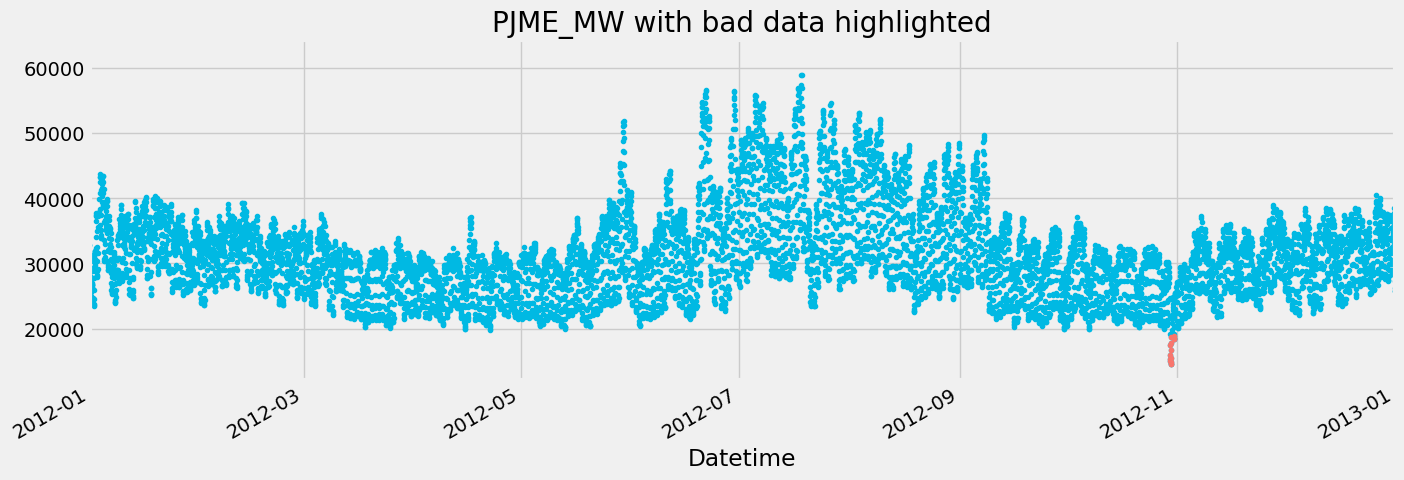

In [86]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

2012년 한 해동안의 전력 소비량 데이터중 특정 낮은 값들을 빨간색으로 표시하여 쉽게 식별할 수 있게 함.

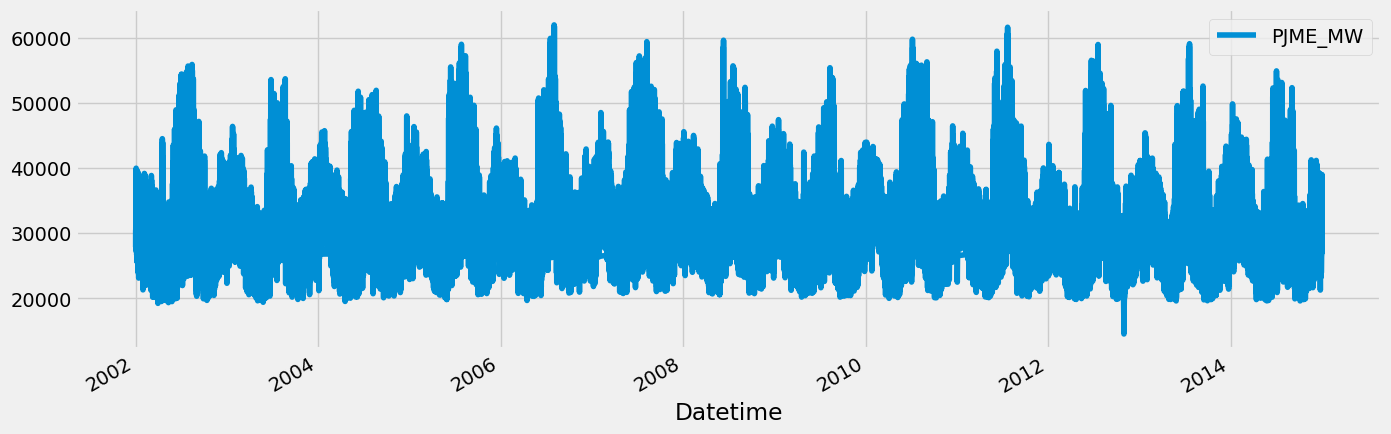

In [87]:
pjme_train.plot(figsize=(15, 5))
plt.show()

2012년에 관측되었던 전력 수요의 급격한 감소가 허리케인 샌디 때문에 발생하였다. 이때 약 800만 가구의 전력 공급이 중단되었기 때문에 뉴욕, 펜실베이니아 등 열 주에서 수백만명의 고객이 전력을 사용할 수 없게 되었다.

https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

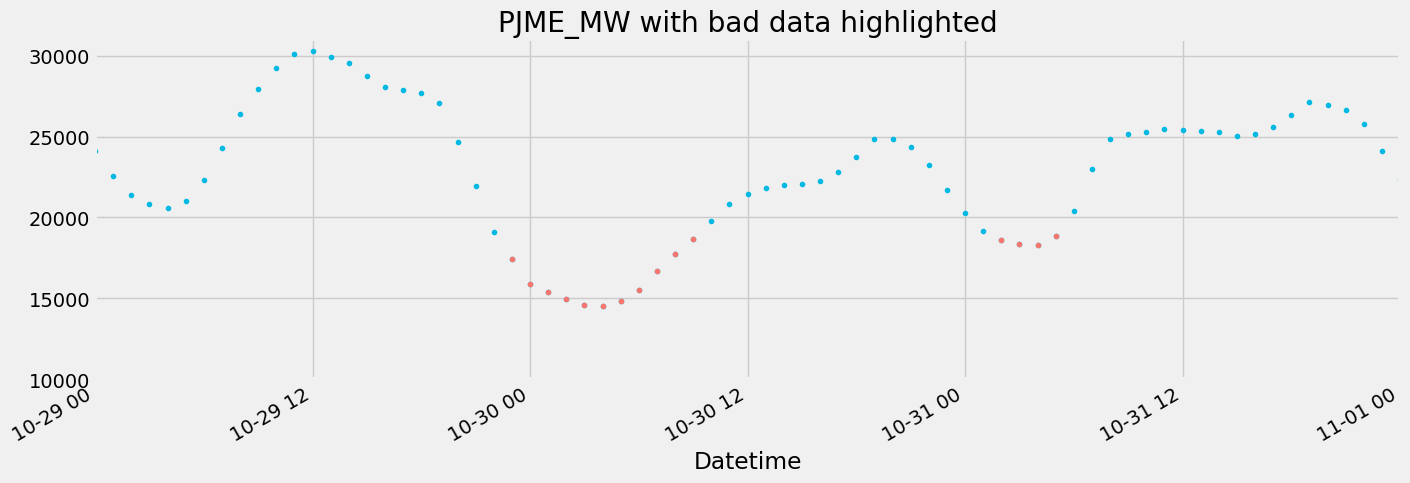

In [88]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

허리케인 샌디가 발생했던 기간에 좀 더 초점을 맞춘 그래프

19000보다 작은 행들을 빨간색 점으로 표시

In [91]:
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

model = prophet.Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

클리닝 후 첫 모델에 비해 성능이 약간 향상되었다

더 많은 데이터 클리닝과 휴일 정보를 함께 사용하면 훨씬 더 좋은 결과를 얻을 수 있다

In [92]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43777604.7917 - MAE 5182.9883 - MAPE 16.5044


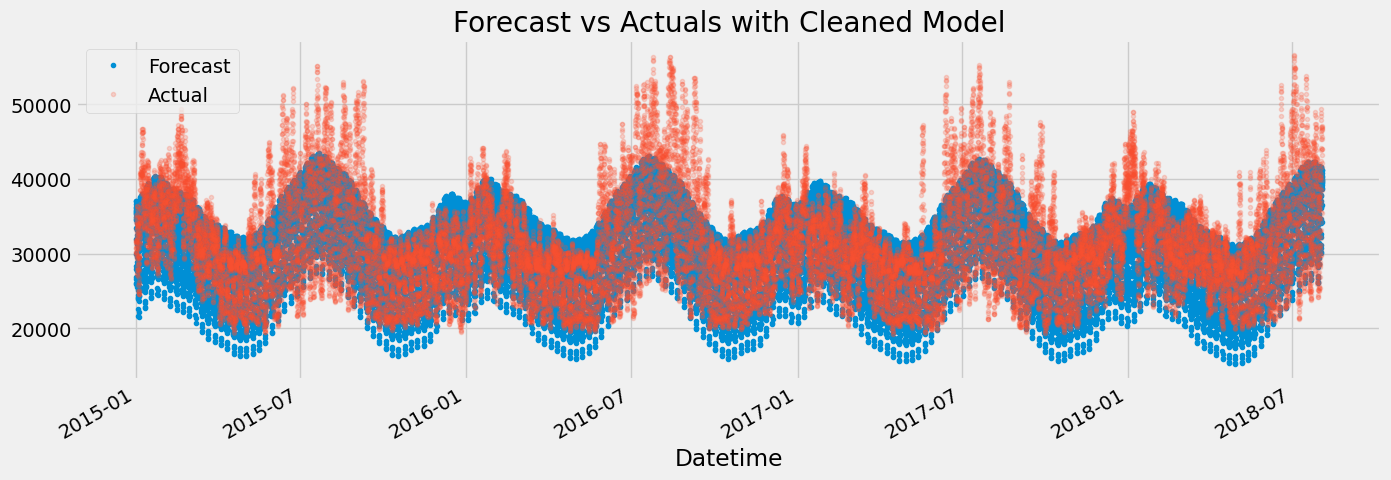

In [93]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()